# 12.REINFORCE算法
> 1992 年，Ronald J. Williams 的论文[《Simple statistical gradient-following algorithms for connectionist reinforcement learning》](https://link.springer.com/article/10.1007/BF00992696)首次系统地提出了 **基于蒙特卡洛** 回报的策略梯度更新方法：**REINFORCE**，它是现代策略梯度方法的起点，是第一个系统性提出并形式化了策略梯度更新规则的算法

**REINFORCE** 算法采用 **蒙特卡洛方法** ，以 **实际的样本回报** $G_t=\sum_{k=t}^T\gamma^{k-t}r_k$ 来表达 **回报** ，是[推导1](./11.策略梯度.ipynb)的进一步推导，这种采用 **从当前时间步 t 开始的未来回报（return-to-go）** 是从 **轨迹推导过来** 的自然变换（是一个完全合法的数学重构，是重排求和结构，不是凭空加进去的经验）:


> $$\begin{gathered}
\nabla_\theta J(\theta)=\mathbb{E}_\pi\left[\sum_{t=0}^T\nabla_\theta\log\pi_\theta(a_t|s_t)\cdot R(\tau)\right]  \\
=\mathbb{E}_\tau\left[\sum_{t=0}^T\nabla_\theta\log\pi_\theta(a_t|s_t)\cdot\underbrace{\left(\sum_{t^{\prime}=0}^T\gamma^{t^{\prime}}r_{t^{\prime}}\right)}_{R(\tau)}\right]
\end{gathered}$$
> 根据**马尔可夫决策过程（MDP）**：未来是由当前s-t决定的 **（一个策略参数 $\theta$ ,在时间t做了动作 $a_t$，它只能影响从 t 开始的奖励）**
> 所以有意忽略掉,诸如 $r_0\cdot\nabla_\theta\log\pi(a_1|s_1)$ ，这些“过去奖励”
> 于是，最终结构自然变为：
> $$=\mathbb{E}_\tau\left[\sum_{t=0}^T\nabla_\theta\log\pi_\theta(a_t|s_t)\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}}r_t\right]$$
> 提取统一系数$\gamma^{t}$
> $$\begin{gathered}
=\mathbb{E}_\tau\left[\sum_{t=0}^T\nabla_\theta\log\pi_\theta(a_t|s_t)\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^{\prime}}\right]  \\
=\mathbb{E}_\tau\left[\sum_{t=0}^T\nabla_\theta\log\pi_\theta(a_t|s_t) G_t\right]  
\end{gathered}$$

> 此时:
- 每次采样得到的一条完整轨迹会被 **多次利用** 来进行策略更新
- 一条完整轨迹当中的每一个时间步t都可以作为一条全新轨迹的初始

>对于一个有限步数的环境来说，REINFORCE 算法中的策略梯度表示为：
$$\nabla_\theta J(\theta)=\mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^TG_t\nabla_\theta\log\pi_\theta(a_t|s_t)\right]=\mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^T\left(\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^{\prime}}\right)\nabla_\theta\log\pi_\theta(a_t|s_t)\right]$$

>对于每一个时间步t开始的那一条轨迹：
$$\nabla_\theta J(\theta)\approx\sum_{t=0}^TG_t\nabla_\theta\log\pi_\theta(a_t|s_t)$$

>损失函数：
$$L(\theta)=-J(\theta)$$
$$\nabla_\theta L(\theta)=-\nabla_\theta J(\theta)$$

>参数更新：
$$\theta_{new}=\theta_{old}+\alpha \nabla_\theta J(\theta)  (最大化期望回报)$$
$$\theta_{new}=\theta_{old}-\alpha \nabla_\theta L(\theta)  (最小化损失函数)$$


## REINFORCE 代码实践：
> 在车杆环境上进行 Actor-Critic 算法的实验

导入相关库：

In [1]:
# 基本库
import numpy as np
from tqdm import tqdm
from utils.smoothing import moving_average
# 神经网络
import torch
import torch.nn.functional as F
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

定义策略网络：

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  # 输出通过 softmax 激活函数转化为一个概率分布，表示每个动作的选择概率

定义 REINFORCE 算法：

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.policy_net(state)  # 输出一个概率分布
        action_dist = torch.distributions.Categorical(probs)  # 创建一个 Categorical 分布，方便从中采样
        action = action_dist.sample()  # 从概率分布中随机采样一个动作的索引
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
        G = 0  # 初始化累积回报
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor(np.array([state_list[i]]), dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()       # 反向传播计算损失函数梯度
        self.optimizer.step()     # 梯度下降,最小化损失函数即最大化期望回报

环境设置（'CartPole-v1'）：

In [4]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env = gym.make('CartPole-v1')  # CartPole-v1 最大回合步数修改到了500步(v0为200)
#env = env.unwrapped # 获取原始环境（绕过 TimeLimit 包装器）解除最大步数500限制
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


超参数设置：

In [5]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
learning_rate = 1e-3
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

num_episodes = 1000

测试与训练:

In [6]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state, info = env.reset()  # 测试阶段(调整参数与对比算法)种子应固定; 训练阶段不固定，提高泛化能力
            done = False
            truncated = False
            while not (done or truncated):  # 杆子倒下或达到最大步数
                action = agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)  # Gymnasium返回值不一样
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, episode=1000, return=302.100]


绘图：

In [7]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
df2 = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df1.to_csv('REINFORCE_returns_data.csv', index=False)
df2.to_csv('REINFORCE_mv_returns_data.csv', index=False)

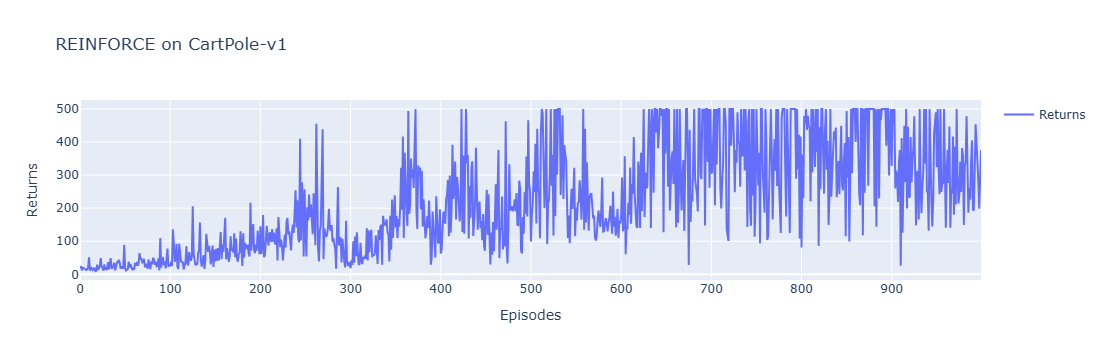

In [10]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('REINFORCE_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='REINFORCE on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

平滑：

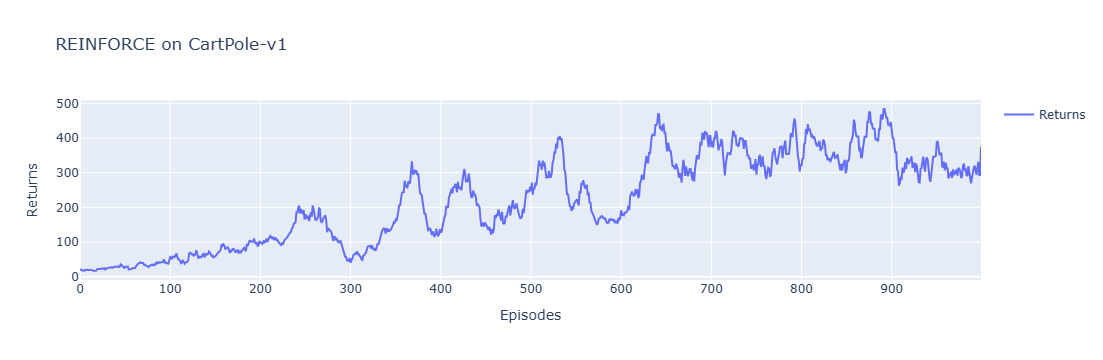

In [11]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('REINFORCE_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='REINFORCE on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

> 可以看出，**REINFORCE** （**无偏估计**保证了算法在理论上可以收敛到局部最优） 能保证在学习率设置合适时收敛到一个**局部最优**
> 但由于**依赖蒙特卡洛采样**整条轨迹回报，导致**梯度方差较大**，造成学习一定程度上的**不稳定**。
> 且REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这要求任务具有**有限的步数**。